In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from keras import layers
from keras.models import Model


In [22]:
# Load dataset
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data.head(15)

# Forward fill missing values
data = data.fillna(method="ffill")
data.head(50)




<ipython-input-22-4166a9794d5d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
# Print unique words and tags in the corpus
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

In [4]:
words = list(data['Word'].unique())
words.append("ENDPAD")  # Adding a padding token
num_words = len(words)
tags = list(data['Tag'].unique())
num_tags = len(tags)

print("Unique tags are:", tags)


Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [6]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)


<ipython-input-5-d744eeac08d5>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


3300

In [7]:
# Create word and tag indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Prepare input sequences
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

# Padding sequences
max_len = 100
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

# Prepare output sequences
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)


In [9]:
input_word = layers.Input(shape=(max_len,))

# Create the embedding layer
embedding_layer = layers.Embedding(input_dim=num_words, output_dim=50,
                                   input_length=max_len)(input_word)

# Add dropout
dropout = layers.SpatialDropout1D(0.1)(embedding_layer)

# Add a Bidirectional LSTM layer
bid_lstm = layers.Bidirectional(
    layers.LSTM(units=100, return_sequences=True,
                recurrent_dropout=0.1))(dropout)

# Add output layer
output = layers.TimeDistributed(
    layers.Dense(num_tags, activation="softmax"))(bid_lstm)

# Define the model
model = Model(input_word, output)

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 50)             │         460,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 200)            │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 17)             │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,067 (2.23 MB)

 Trainable params: 585,067 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [17]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=30,
    epochs=10,
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.9920 - loss: 0.0291 - val_accuracy: 0.9858 - val_loss: 0.0550
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - accuracy: 0.9932 - loss: 0.0257 - val_accuracy: 0.9857 - val_loss: 0.0529
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.9942 - loss: 0.0224 - val_accuracy: 0.9863 - val_loss: 0.0539
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 288ms/step - accuracy: 0.9949 - loss: 0.0191 - val_accuracy: 0.9863 - val_loss: 0.0543
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.9956 - loss: 0.0168 - val_accuracy: 0.9864 - val_loss: 0.0545
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.9958 - loss: 0.0153 - val_accuracy: 0.9863 - val_loss: 0.0559
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 284ms/step - accuracy: 0.9963 - loss: 0.0135 - val_accuracy: 0.9859 - val_loss: 0.0559
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accu

Bhargava S 212221040029


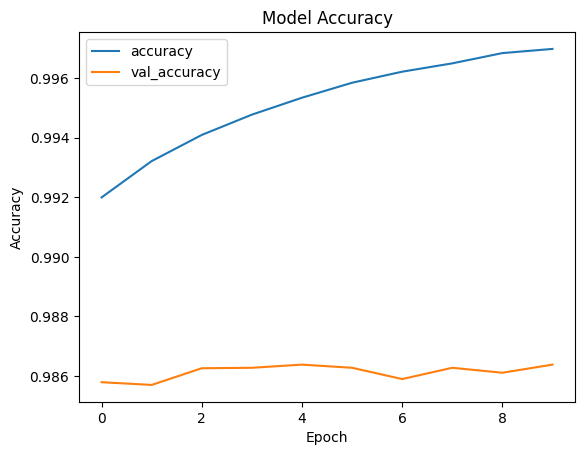

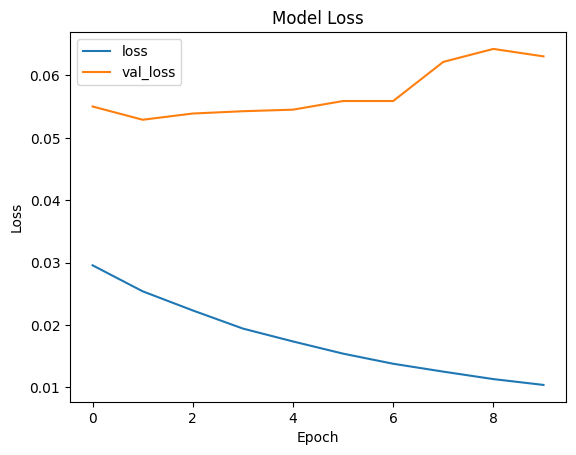

In [21]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

print("Bhargava S 212221040029")
# Plot accuracy
metrics[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot loss
metrics[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [14]:
i = 25
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]

# Display predicted vs true labels
print("Name: Bhargava     Reg No: 212221040029")
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" * 30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Name: Bhargava     Reg No: 212221040029
Word           True 	 Pred

------------------------------
Officials      O	O
at             O	O
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
Embassy        I-geo	I-org
in             O	O
Nepal          B-gpe	B-gpe
say            O	O
they           O	O
are            O	O
alarmed        O	O
by             O	O
the            O	O
possibility    O	O
of             O	O
an             O	O
alliance       O	O
between        O	O
Maoist         B-geo	B-org
rebels         O	O
and            O	O
political      O	O
parties        O	O
in             O	O
the            O	O
Himalayan      B-geo	O
kingdom        O	O
.              O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
ca